In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/raf-db-dataset/test_labels.csv
/kaggle/input/raf-db-dataset/train_labels.csv
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2941_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2717_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2499_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2724_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2935_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2419_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2779_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2566_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2805_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2495_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2422_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2413_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_2565_aligned.jpg
/kaggle/input/raf-db-dataset/DATASET/test/7/test_24

### Code:

In [2]:
import os
import cv2
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm

# Scikit-learn utilities
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    RocCurveDisplay,
    confusion_matrix,
    roc_curve,
    auc
)

# TensorFlow / Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [3]:
classes = ["surprise", "fear", "disgust", "happy", "sad", "angry", "neutral"]

label_map = {label: (idx + 1) for idx, label in enumerate(classes)}

print(label_map)

{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [4]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            # converting img to rgb from bgr as well because rgb is std
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

In [5]:
train_images, train_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/train', label_map)
test_images, test_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/test', label_map)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
train_percentage = (len(train_images)/(len(train_images) + len(test_images)))*100
test_percentage = (len(test_images)/(len(train_images) + len(test_images)))*100

print(train_percentage, test_percentage)

79.99869613403742 20.00130386596258


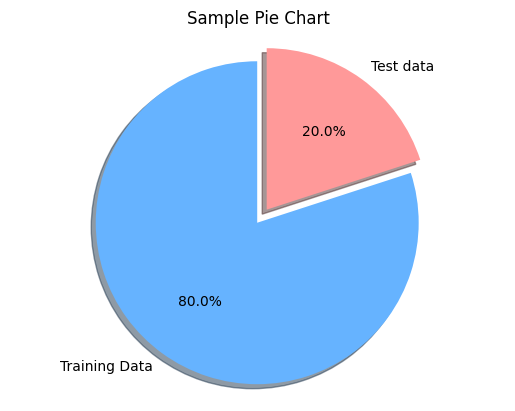

In [7]:
# Data
labels = ['Training Data', 'Test data']
sizes = [train_percentage, test_percentage]  # percentages
colors = ['#66b3ff', '#ff9999']  # optional colors
explode = (0.1, 0)  # explode the 1st slice (Category A)

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode, shadow=True)
plt.title('Sample Pie Chart')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [8]:
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]

In [9]:
total_train = sum(train_counts)
total_test = sum(test_counts)

# class wise percentages
train_percentages = [((count/ total_train)*100) for count in train_counts]
test_percentages = [((count/ total_test)*100) for count in test_counts]

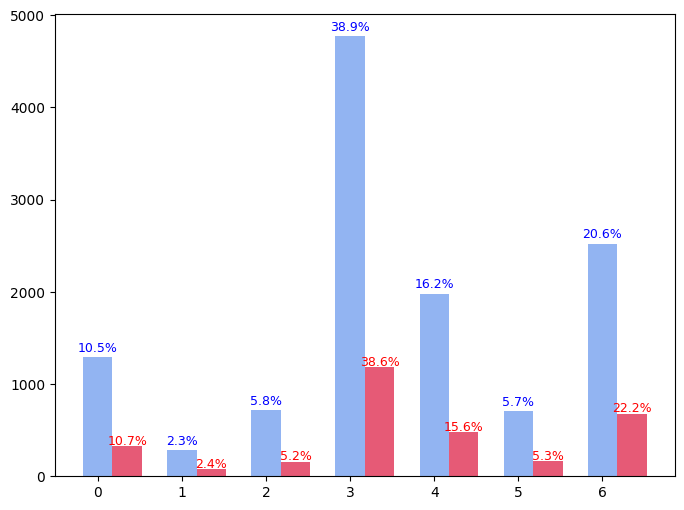

In [10]:
# plotting bar plot
x = range(len(classes))
bar_width = 0.35

plt.figure(figsize=(8, 6))

plt.bar(x, train_counts, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label="Test", alpha=0.7, color="crimson")


for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(
        i, 
        train_count + 0.005 * total_train, 
        f"{train_percentages[i]:.1f}%", 
        ha='center', 
        color="blue", 
        fontsize=9
    )
    plt.text(
        i + bar_width, 
        test_count + 0.005 * total_test, 
        f"{test_percentages[i]:.1f}%", 
        ha='center', 
        color="red", 
        fontsize=9
    )

In [11]:
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)


X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

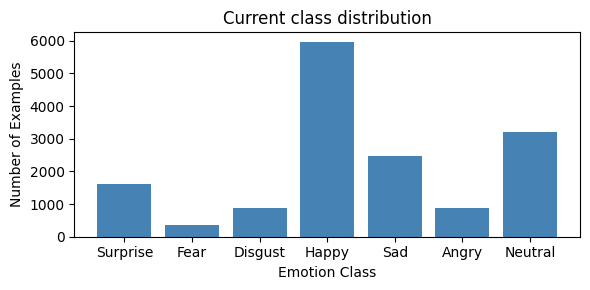

In [12]:
def plot_class_distribution(y, title):
    train_label_counts_resampled = Counter(y)

    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]

    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

    plt.bar(x_labels, train_counts_resampled, color="steelblue")

    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(Y_train, "Current class distribution")

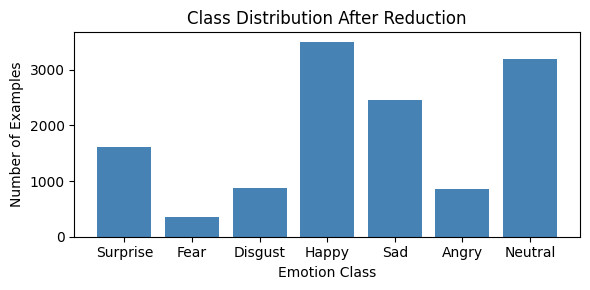

In [13]:
import numpy as np

def reduce_class(X, y, target_class, target_size):
    # Step 1: Separate indices of target and non-target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]

    # Step 2: Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)

    # Step 3: Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]

    return X_reduced, y_reduced

target_class = 4 # The 'happy' class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# Plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction" )

In [14]:
def augment_classes(images, labels, target_counts):
    # Initialize the image augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        vertical_flip=False,
        horizontal_flip=True,
        channel_shift_range=50.0,
        fill_mode='nearest'
    )

    augmented_images = images.copy()
    augmented_labels = labels.copy()

    for target_class, target_count in target_counts.items():
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Class {target_class}: {len(class_images)} original samples, augmenting with {augment_count} new samples.')
            class_images_augmented = []
            class_labels_augmented = []

            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)

                if len(class_images_augmented) >= augment_count:
                    break

            augmented_images = np.concatenate([augmented_images, np.array(class_images_augmented)])
            augmented_labels = np.concatenate([augmented_labels, np.array(class_labels_augmented)])

    return augmented_images, augmented_labels



In [15]:
target_counts = {1: 3500, 2: 3500, 3: 3500, 4: 3500, 5: 3500, 6: 3500, 7: 3500}
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

Class 1: 1619 original samples, augmenting with 1881 new samples.
Class 2: 355 original samples, augmenting with 3145 new samples.
Class 3: 877 original samples, augmenting with 2623 new samples.
Class 5: 2460 original samples, augmenting with 1040 new samples.
Class 6: 867 original samples, augmenting with 2633 new samples.
Class 7: 3204 original samples, augmenting with 296 new samples.


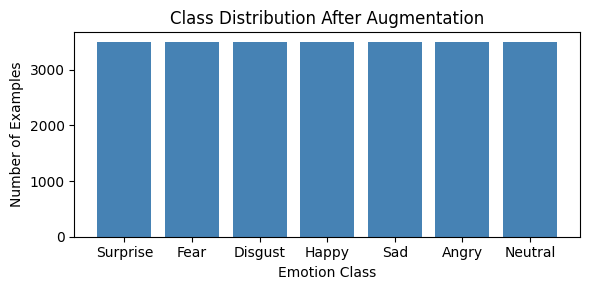

In [16]:
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")

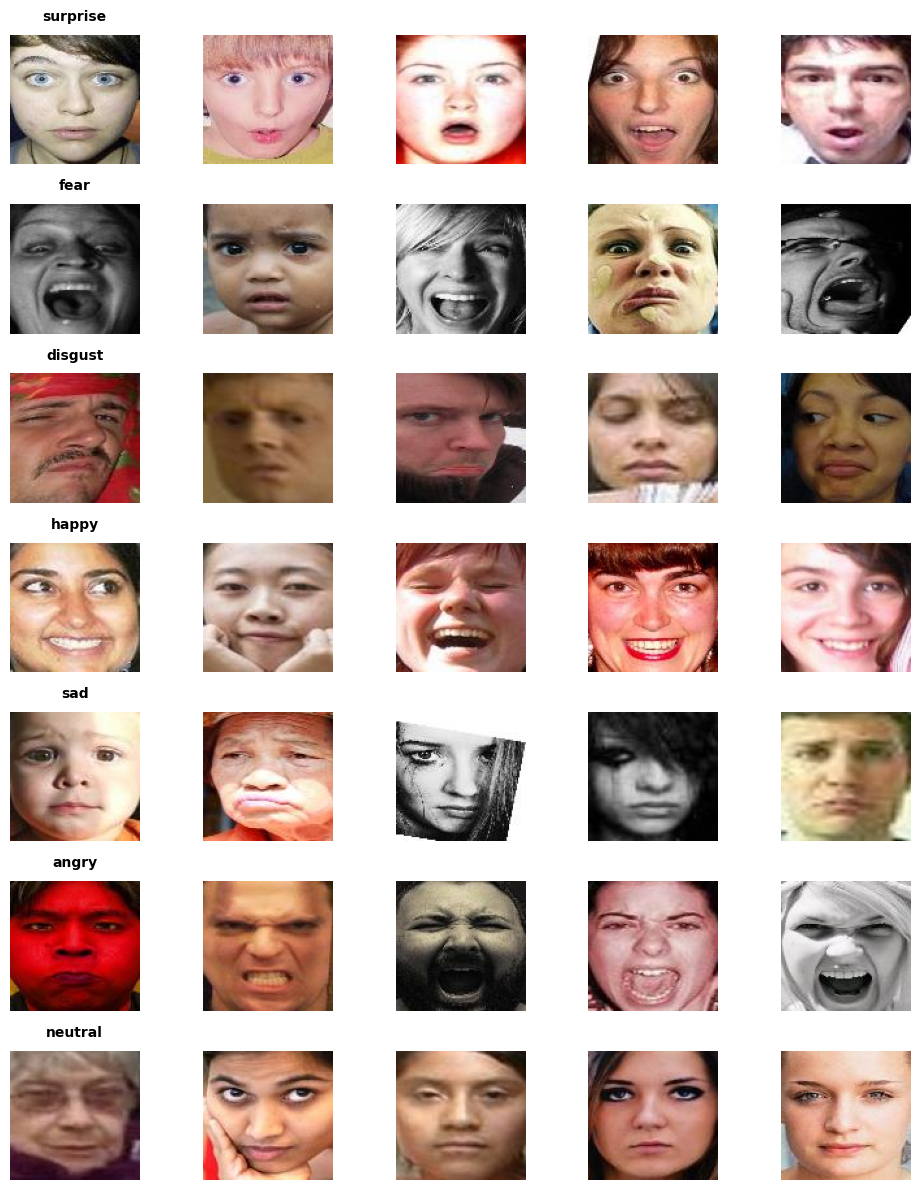

In [17]:
def show_examples(train_images, train_labels, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))

    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')

        # Display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_examples(X_train, Y_train, classes)

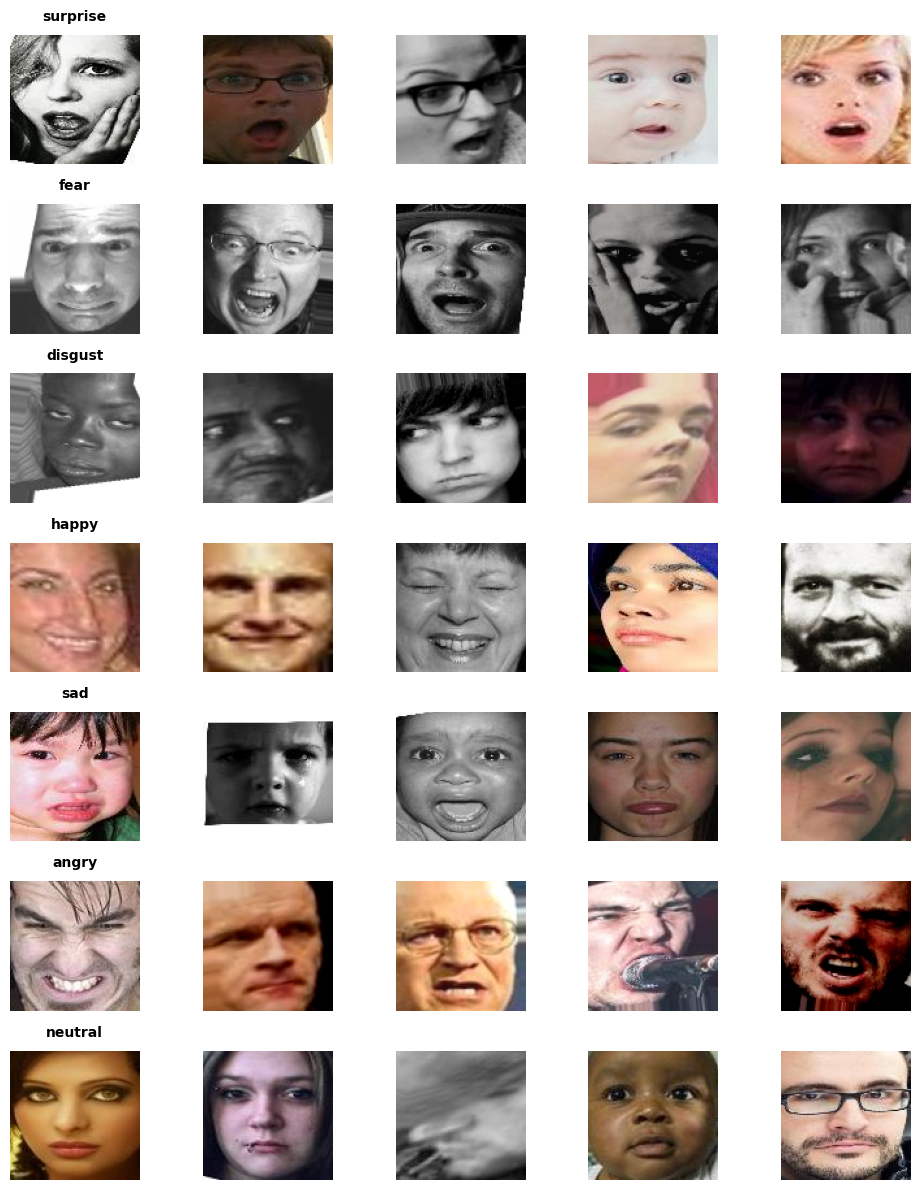

In [18]:
show_examples(X_train_augmented, y_train_augmented, classes)

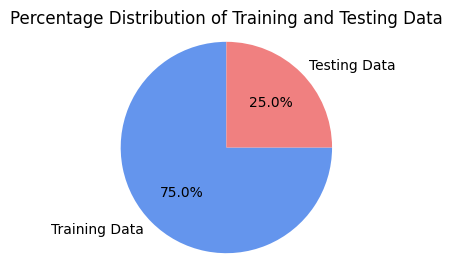

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented,
                                                    y_train_augmented,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

total_images = len(X_train) + len(X_test)

train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

In [20]:
# Normalization function
def normalize_images(images):
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

# Reshaping function
def reshape_images(images):
    return images.reshape((images.shape[0], 100, 100, 3))

train_images_reshaped = reshape_images(train_images_normalized)
test_images_reshaped = reshape_images(test_images_normalized)

In [21]:
print(f"Training images shape: {train_images_reshaped.shape}")
print(f"Testing images shape: {test_images_reshaped.shape}")

Training images shape: (18375, 100, 100, 3)
Testing images shape: (6125, 100, 100, 3)


In [22]:
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat  = to_categorical(Y_test - 1, num_classes=len(classes))

In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(train_images_reshaped, Y_train_cat, batch_size=64)

In [24]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_reshaped[0].shape)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754496529.032647      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754496529.034688      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True)

CNN_History = cnn_model.fit(
    train_generator,
    epochs=10,  # suggested epochs is 60
    batch_size=32,
    validation_data=(test_images_reshaped, Y_test_cat),
    callbacks=[reduce_lr, early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1754496534.194343     100 service.cc:148] XLA service 0x7b592000f990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754496534.195626     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754496534.195651     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754496534.686122     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/288 ━━━━━━━━━━━━━━━━━━━━ 24s 84ms/step - accuracy: 0.1736 - loss: 1.9751

I0000 00:00:1754496539.565713     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.1957 - loss: 1.9064 - val_accuracy: 0.3055 - val_loss: 1.7461 - learning_rate: 0.0010
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.3115 - loss: 1.7417 - val_accuracy: 0.4296 - val_loss: 1.4902 - learning_rate: 0.0010
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.4156 - loss: 1.5435 - val_accuracy: 0.5234 - val_loss: 1.2776 - learning_rate: 0.0010
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.5649 - loss: 1.1872 - val_accuracy: 0.6225 - val_loss: 1.0242 - learning_rate: 0.0010
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.5805 - loss: 1.1186 - val_accuracy: 0.6454 - val_loss: 0.9549 - learning_rate: 0.0010
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.6129 - loss: 1.0598 - val_accuracy: 0.6278 - val_loss: 0.9864 - learning_rate: 0.0010
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 45s 155ms/step - accuracy: 0.6192 - loss:

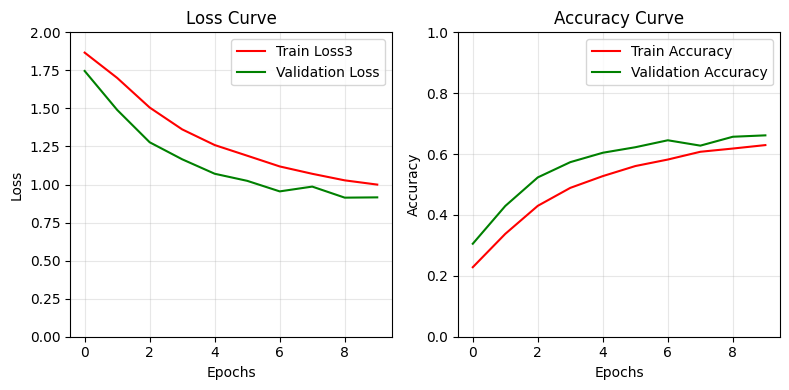

In [26]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss3', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
train_CNNresult = cnn_model.evaluate(train_images_reshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_reshaped, Y_test_cat)

print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))


575/575 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6889 - loss: 0.8402
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6559 - loss: 0.9158
Train Loss: 83.64%
Train Accuracy: 69.00%

Test Loss: 91.56%
Test Accuracy: 66.16%


In [28]:
#Testing purposes only
print(train_classes)
print(train_percentages)

print(len(Y_train))
print(len(X_train))

[1, 2, 3, 4, 5, 6, 7]
[10.512590660907833, 2.2899519191589928, 5.84304457664412, 38.888436150273, 16.151902860402576, 5.74525303561242, 20.56882079700106]
18375
18375
